In [2]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import wget

In [4]:
bbc_text=wget.download('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv',bar=None)

In [10]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [6]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


In [8]:
with open(bbc_text,'r') as csvfile:
    reader=csv.reader(csvfile,delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence=row[1]
        for word in stopwords:
            token=" "+word+" "
            sentence=sentence.replace(token," ")
            sentence=sentence.replace("  "," ")
        sentences.append(sentence)
print(len(labels))
print(len(sentences))

2225
2225


In [13]:
train_size = int(len(sentences) * training_portion)

train_sentences=sentences[:train_size]
train_labels=labels[:train_size]

validation_sentences=sentences[train_size:]
validation_labels=labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [27]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index=tokenizer.word_index

train_sequences=tokenizer.texts_to_sequences(train_sentences)
train_padded=pad_sequences(train_sequences,padding=padding_type,maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))


449
120
200
120
192
120


In [28]:
validation_sequences=tokenizer.texts_to_sequences(validation_sentences)
validation_padded=pad_sequences(validation_sequences,padding=padding_type,maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


In [29]:
label_tokenizer=Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq=np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq=np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [30]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24,activation='relu'),
    tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [31]:
history=model.fit(train_padded,
                 training_label_seq,
                 epochs=30,
                 validation_data=(validation_padded,validation_label_seq),
                 verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/30
 - 1s - loss: 1.7590 - acc: 0.2303 - val_loss: 1.7146 - val_acc: 0.2270
Epoch 2/30
 - 0s - loss: 1.6565 - acc: 0.2309 - val_loss: 1.5971 - val_acc: 0.2517
Epoch 3/30
 - 0s - loss: 1.5167 - acc: 0.3713 - val_loss: 1.4467 - val_acc: 0.4539
Epoch 4/30
 - 0s - loss: 1.3399 - acc: 0.4820 - val_loss: 1.2638 - val_acc: 0.6135
Epoch 5/30
 - 0s - loss: 1.1463 - acc: 0.6893 - val_loss: 1.0897 - val_acc: 0.7326
Epoch 6/30
 - 0s - loss: 0.9691 - acc: 0.8191 - val_loss: 0.9262 - val_acc: 0.8427
Epoch 7/30
 - 0s - loss: 0.8048 - acc: 0.8713 - val_loss: 0.7841 - val_acc: 0.8809
Epoch 8/30
 - 0s - loss: 0.6590 - acc: 0.9169 - val_loss: 0.6564 - val_acc: 0.8989
Epoch 9/30
 - 0s - loss: 0.5378 - acc: 0.9337 - val_loss: 0.5574 - val_acc: 0.9079
Epoch 10/30
 - 0s - loss: 0.4393 - acc: 0.9438 - val_loss: 0.4901 - val_acc: 0.9034
Epoch 11/30
 - 0s - loss: 0.3660 - acc: 0.9489 - val_loss: 0.4160 - val_acc: 0.9191
Epoch 12/30
 - 0s - loss: 0.3056 - acc

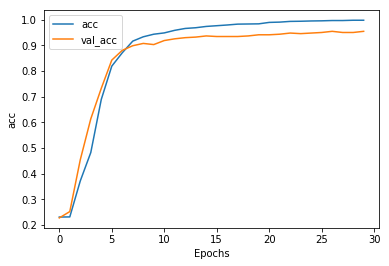

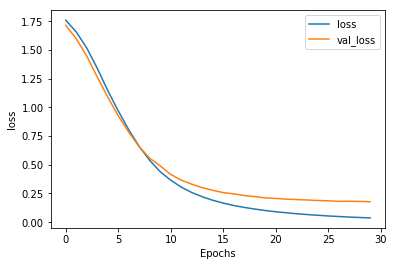

In [33]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [34]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [35]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(1000, 16)


In [36]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [37]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')